In [1]:
!pip install xgboost scikit-learn pandas numpy matplotlib seaborn joblib
!pip install streamlit pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 68.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline # Use imblearn's pipeline for SMOTE integration

from xgboost import XGBClassifier

df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# 'TotalCharges' is an object type because of spaces/empty strings, which represent missing values
# for customers with tenure = 0. We convert these to NaN and then to float.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Handle missing 'TotalCharges' by imputing with 0 (since tenure is 0 for these)
df['TotalCharges'].fillna(0, inplace=True)

# Drop 'customerID' as it's an identifier and not a feature
df = df.drop('customerID', axis=1)

# Convert the target variable 'Churn' to numeric (0 and 1)
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

print("Cleaned Data Info:")
print(df.info())
print("\nChurn Rate:")
print(df['Churn'].value_counts(normalize=True))

Cleaned Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 

/tmp/ipython-input-4117015320.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)


<Axes: >

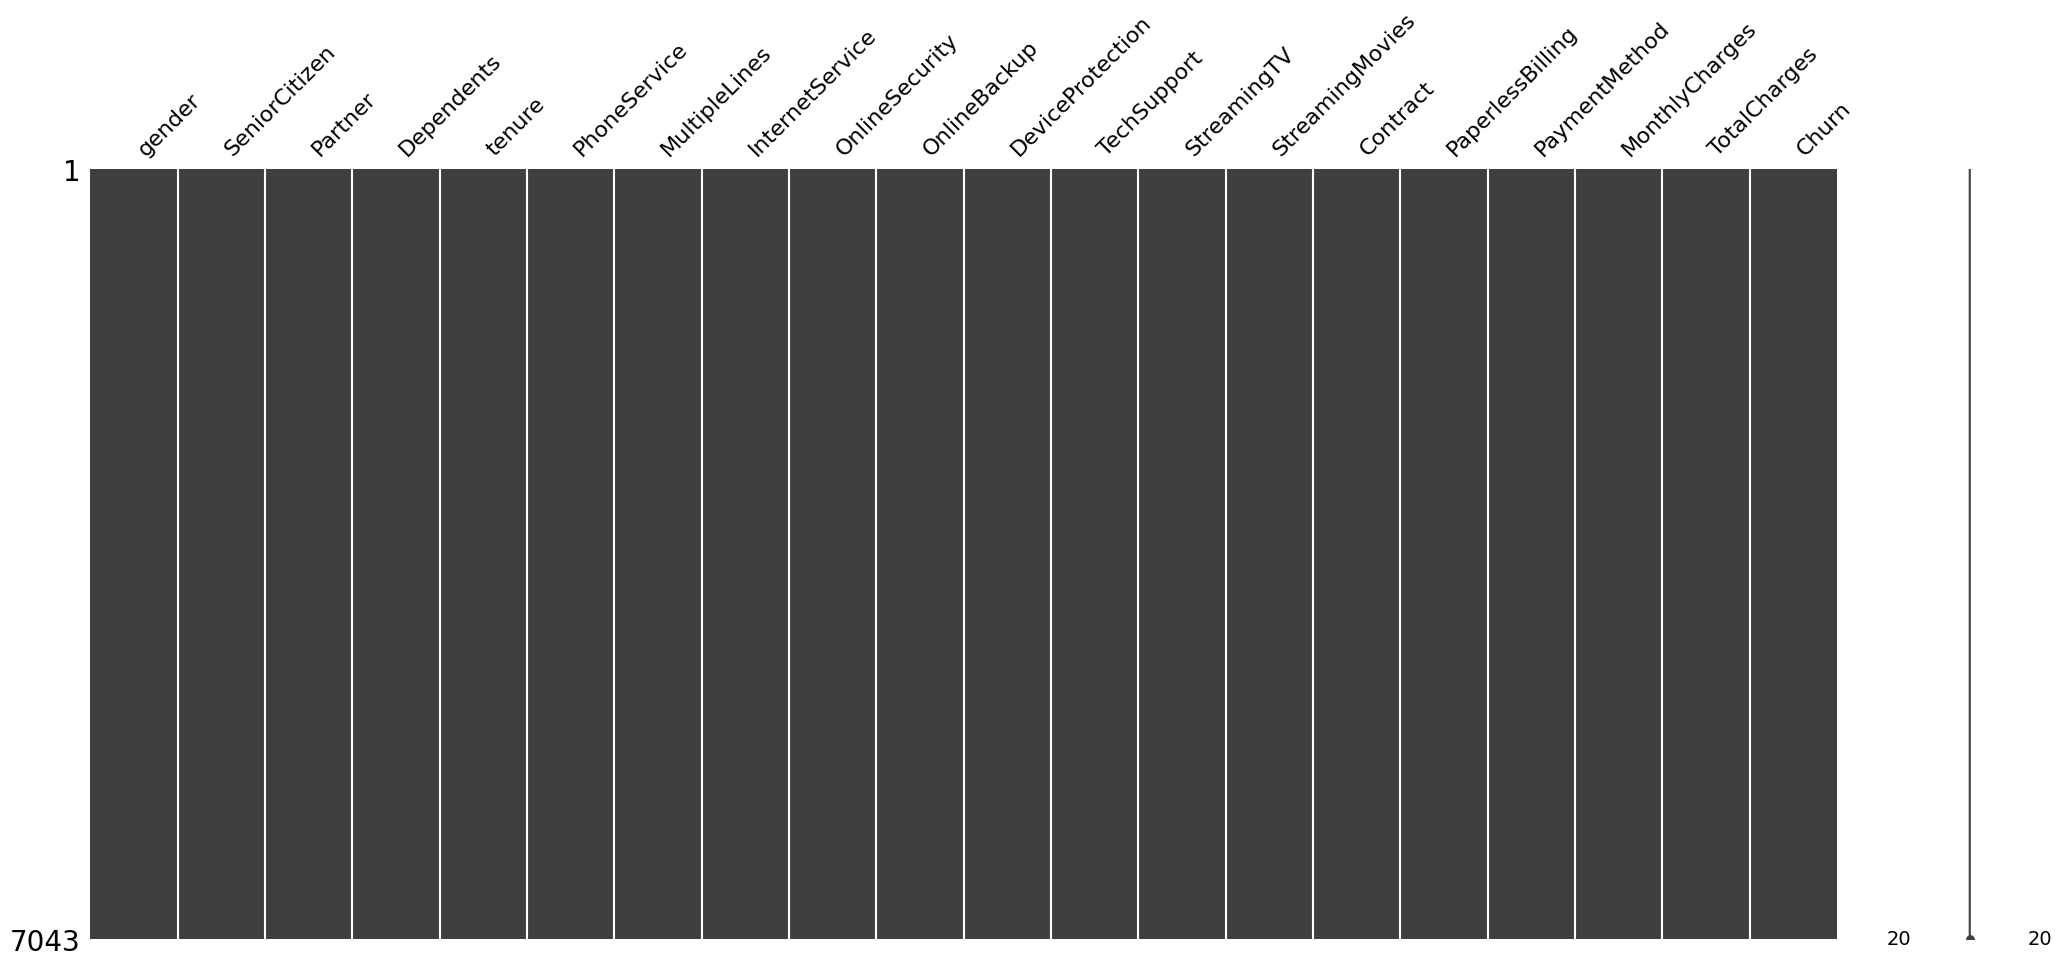

In [3]:
import missingno as msn
msn.matrix(df)
#There is no null values in every single feature!

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import joblib


# All numerical features for scaling
numerical_features = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

# All categorical (object) features for One-Hot Encoding
categorical_features = [
    'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
    'PaperlessBilling', 'PaymentMethod'
]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='drop'
)

X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train/Test split: {X_train.shape[0]} / {X_test.shape[0]}")

Train/Test split: 5634 / 1409


Starting Randomized Search (This may take a few minutes)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:33:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best Hyperparameters found by Randomized Search:
{'classifier__subsample': 0.9, 'classifier__n_estimators': 200, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.05, 'classifier__gamma': 0.1, 'classifier__colsample_bytree': 0.9}

--- Model Evaluation ---
Test Set ROC-AUC Score: 0.8424

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1035
           1       0.57      0.70      0.62       374

    accuracy                           0.78      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.80      0.78      0.79      1409



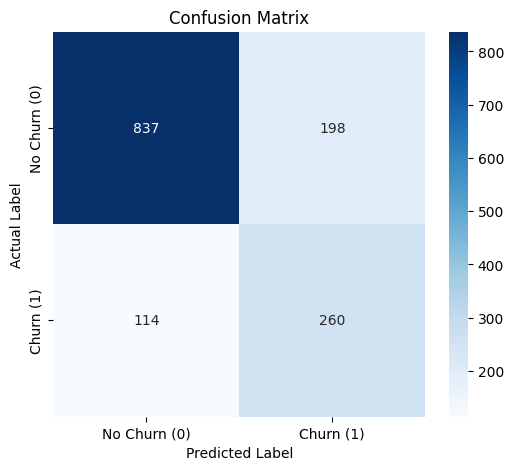


Best model saved to 'churn_prediction_model.pkl'
Training column order saved to 'train_columns.pkl'


In [5]:
model_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('sampler', SMOTE(random_state=42, sampling_strategy='minority')),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.7, 0.9, 1.0],
    'classifier__colsample_bytree': [0.7, 0.9, 1.0],
    'classifier__gamma': [0, 0.1, 0.5],
}

random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_grid,
    n_iter=20,
    scoring='roc_auc',
    cv=3, #
    verbose=2,
    random_state=42,
    n_jobs=-1
)

print("Starting Randomized Search (This may take a few minutes)...")
random_search.fit(X_train, y_train)

# Get the best model
best_model = random_search.best_estimator_

print("\nBest Hyperparameters found by Randomized Search:")
print(random_search.best_params_)

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\n--- Model Evaluation ---")
print(f"Test Set ROC-AUC Score: {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn (0)', 'Churn (1)'],
            yticklabels=['No Churn (0)', 'Churn (1)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix_fixed.png') # Use a new file name to ensure it saves
plt.show()

joblib.dump(best_model, 'churn_prediction_model.pkl')
print("\nBest model saved to 'churn_prediction_model.pkl'")

train_cols = X_train.columns.tolist()
joblib.dump(train_cols, 'train_columns.pkl')
print("Training column order saved to 'train_columns.pkl'")

In [6]:
# Save the best model and the preprocessor
joblib.dump(best_model, 'churn_prediction_model.pkl')
print("Best model saved to 'churn_prediction_model.pkl'")

# Save the original training column names (important for Streamlit app to maintain feature order)
train_cols = X_train.columns.tolist()
joblib.dump(train_cols, 'train_columns.pkl')
print("Training column order saved to 'train_columns.pkl'")

Best model saved to 'churn_prediction_model.pkl'
Training column order saved to 'train_columns.pkl'


In [7]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib
import numpy as np

# --- 1. Load Model and Assets ---
@st.cache_resource
def load_assets():
    try:
        model = joblib.load('churn_prediction_model.pkl')
        train_cols = joblib.load('train_columns.pkl')
        return model, train_cols
    except FileNotFoundError:
        st.error("Model or columns file not found. Please ensure 'churn_prediction_model.pkl' and 'train_columns.pkl' are in the same directory.")
        return None, None

model, train_cols = load_assets()

st.set_page_config(page_title="Telco Churn Prediction", layout="wide")
st.title("Telco Customer Churn Predictor ")
st.markdown("Enter customer details to predict the probability of churn (leaving the company).")

if model:
    with st.sidebar:
        st.header("Customer Profile")
        gender = st.radio("Gender", ['Male', 'Female'])
        senior_citizen = st.radio("Senior Citizen", [0, 1], format_func=lambda x: 'Yes' if x == 1 else 'No')
        partner = st.radio("Partner", ['Yes', 'No'])
        dependents = st.radio("Dependents", ['Yes', 'No'])
        tenure = st.slider("Tenure (Months)", 1, 72, 24)

    st.header("Service and Contract Details")

    col1, col2, col3 = st.columns(3)

    with col1:
        phone_service = st.radio("Phone Service", ['Yes', 'No'])
        multiple_lines = st.selectbox("Multiple Lines", ['No', 'Yes', 'No phone service'])
        internet_service = st.selectbox("Internet Service", ['DSL', 'Fiber optic', 'No'])

    with col2:
        contract = st.selectbox("Contract Type", ['Month-to-month', 'One year', 'Two year'])
        payment_method = st.selectbox("Payment Method", ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)'])
        paperless_billing = st.radio("Paperless Billing", ['Yes', 'No'])

    with col3:
        monthly_charges = st.number_input("Monthly Charges ($)", 18.0, 120.0, 70.0, step=0.01)
        total_charges = st.number_input("Total Charges ($)", 18.0, 9500.0, 1000.0, step=0.01)

    st.subheader("Add-on Services")
    col_addons = st.columns(5)

    internet_options = ['No internet service', 'Yes', 'No']

    disabled_addons = internet_service == 'No'
    if disabled_addons:
        addon_state = 'No internet service'
    else:
        addon_state = 'No'

    with col_addons[0]:
        online_security = st.selectbox("Online Security", internet_options, index=internet_options.index(addon_state), disabled=disabled_addons)
    with col_addons[1]:
        online_backup = st.selectbox("Online Backup", internet_options, index=internet_options.index(addon_state), disabled=disabled_addons)
    with col_addons[2]:
        device_protection = st.selectbox("Device Protection", internet_options, index=internet_options.index(addon_state), disabled=disabled_addons)
    with col_addons[3]:
        tech_support = st.selectbox("Tech Support", internet_options, index=internet_options.index(addon_state), disabled=disabled_addons)
    with col_addons[4]:
        streaming_tv = st.selectbox("Streaming TV", internet_options, index=internet_options.index(addon_state), disabled=disabled_addons)
        streaming_movies = st.selectbox("Streaming Movies", internet_options, index=internet_options.index(addon_state), disabled=disabled_addons)


    if st.button("Predict Churn Probability", type="primary"):
        input_data = pd.DataFrame({
            'gender': [gender],
            'SeniorCitizen': [senior_citizen],
            'Partner': [partner],
            'Dependents': [dependents],
            'tenure': [tenure],
            'PhoneService': [phone_service],
            'MultipleLines': [multiple_lines],
            'InternetService': [internet_service],
            'OnlineSecurity': [online_security],
            'OnlineBackup': [online_backup],
            'DeviceProtection': [device_protection],
            'TechSupport': [tech_support],
            'StreamingTV': [streaming_tv],
            'StreamingMovies': [streaming_movies],
            'Contract': [contract],
            'PaperlessBilling': [paperless_billing],
            'PaymentMethod': [payment_method],
            'MonthlyCharges': [monthly_charges],
            'TotalCharges': [total_charges]
        })

        input_data = input_data[train_cols]

        try:
            churn_proba = model.predict_proba(input_data)[0][1]
            churn_percent = churn_proba * 100

            st.markdown("---")
            st.subheader("Prediction Result")

            if churn_proba >= 0.5:
                st.error(f" High Risk of Churn: {churn_percent:.2f}%")
                st.markdown("---")
                st.markdown("**Recommended Action:** The customer is likely to churn. Initiate a retention offer (e.g., a discounted long-term contract or a free service upgrade).")
            else:
                st.success(f" Low Risk of Churn: {churn_percent:.2f}%")
                st.markdown("---")
                st.markdown("**Recommended Action:** The customer is likely to stay. Continue monitoring and consider a targeted upselling campaign for higher value services.")

            st.progress(churn_proba, text=f"Churn Probability: {churn_percent:.2f}%")

        except Exception as e:
            st.error(f"An error occurred during prediction: {e}")

Writing app.py


In [8]:
from pyngrok import ngrok
import subprocess
import time

ngrok.set_auth_token("33N8aDY3T5EQb72svd5Sy3jy3G8_4z8iguAK4mpfxkCd1Aah4")


print("Starting Streamlit...")
p = subprocess.Popen(['streamlit', 'run', 'app.py'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

time.sleep(5)

try:
    public_url = ngrok.connect(8501)
    print(f"\n---  Streamlit App Deployed! ---")
    print(f"Your Public URL: {public_url}")
    print("\nClick the link above to access your Churn Prediction App.")

except Exception as e:
    print(f"\nCould not start ngrok tunnel: {e}")
    print("If you still see this error, ensure your token is valid and you have accepted the terms.")



Starting Streamlit...

---  Streamlit App Deployed! ---
Your Public URL: NgrokTunnel: "https://gratuitous-debroah-distraughtly.ngrok-free.dev" -> "http://localhost:8501"

Click the link above to access your Churn Prediction App.
